## **Downloading the File**

In [ ]:
!gdown "https://drive.google.com/uc?export=download&id=1LCPDJDIZwDDkUSDl9AeM4N5UnCZGdSON"

Downloading...
From: https://drive.google.com/uc?export=download&id=1LCPDJDIZwDDkUSDl9AeM4N5UnCZGdSON
To: /content/Smart Meter Data - Copy.csv
100% 11.7M/11.7M [00:00<00:00, 58.1MB/s]


## **Data Preprocessing**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import euclidean
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


# Load the dataset
df = pd.read_csv("/content/Smart Meter Data - Copy.csv")

# Drop columns that are all zero
zero_columns = df.columns[(df == 0).all()]
new_df = df.drop(zero_columns, axis=1)

# Set the first column as the index
first_column = new_df.iloc[:, 0]
new_df.set_index(first_column, inplace=True)
new_df = new_df.iloc[:, 1:]
new_df.index = pd.to_datetime(new_df.index)

# Filter data for summer months (May to September)
def filter_timeseries_dataframe(df):
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)
    return df[(df.index.month >= 5) & (df.index.month <= 9) & ((df.index.month > 5) | (df.index.day >= 1)) & ((df.index.month < 9) | (df.index.day <= 1))]

summer_df = filter_timeseries_dataframe(new_df)
final_df = summer_df.resample('D').sum()



<ipython-input-4-1c8916888618>:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  new_df.index = pd.to_datetime(new_df.index)


## **Wards Clustering Diagram**

<ipython-input-5-b77bd43731d5>:18: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(dtw_matrix, method="ward")


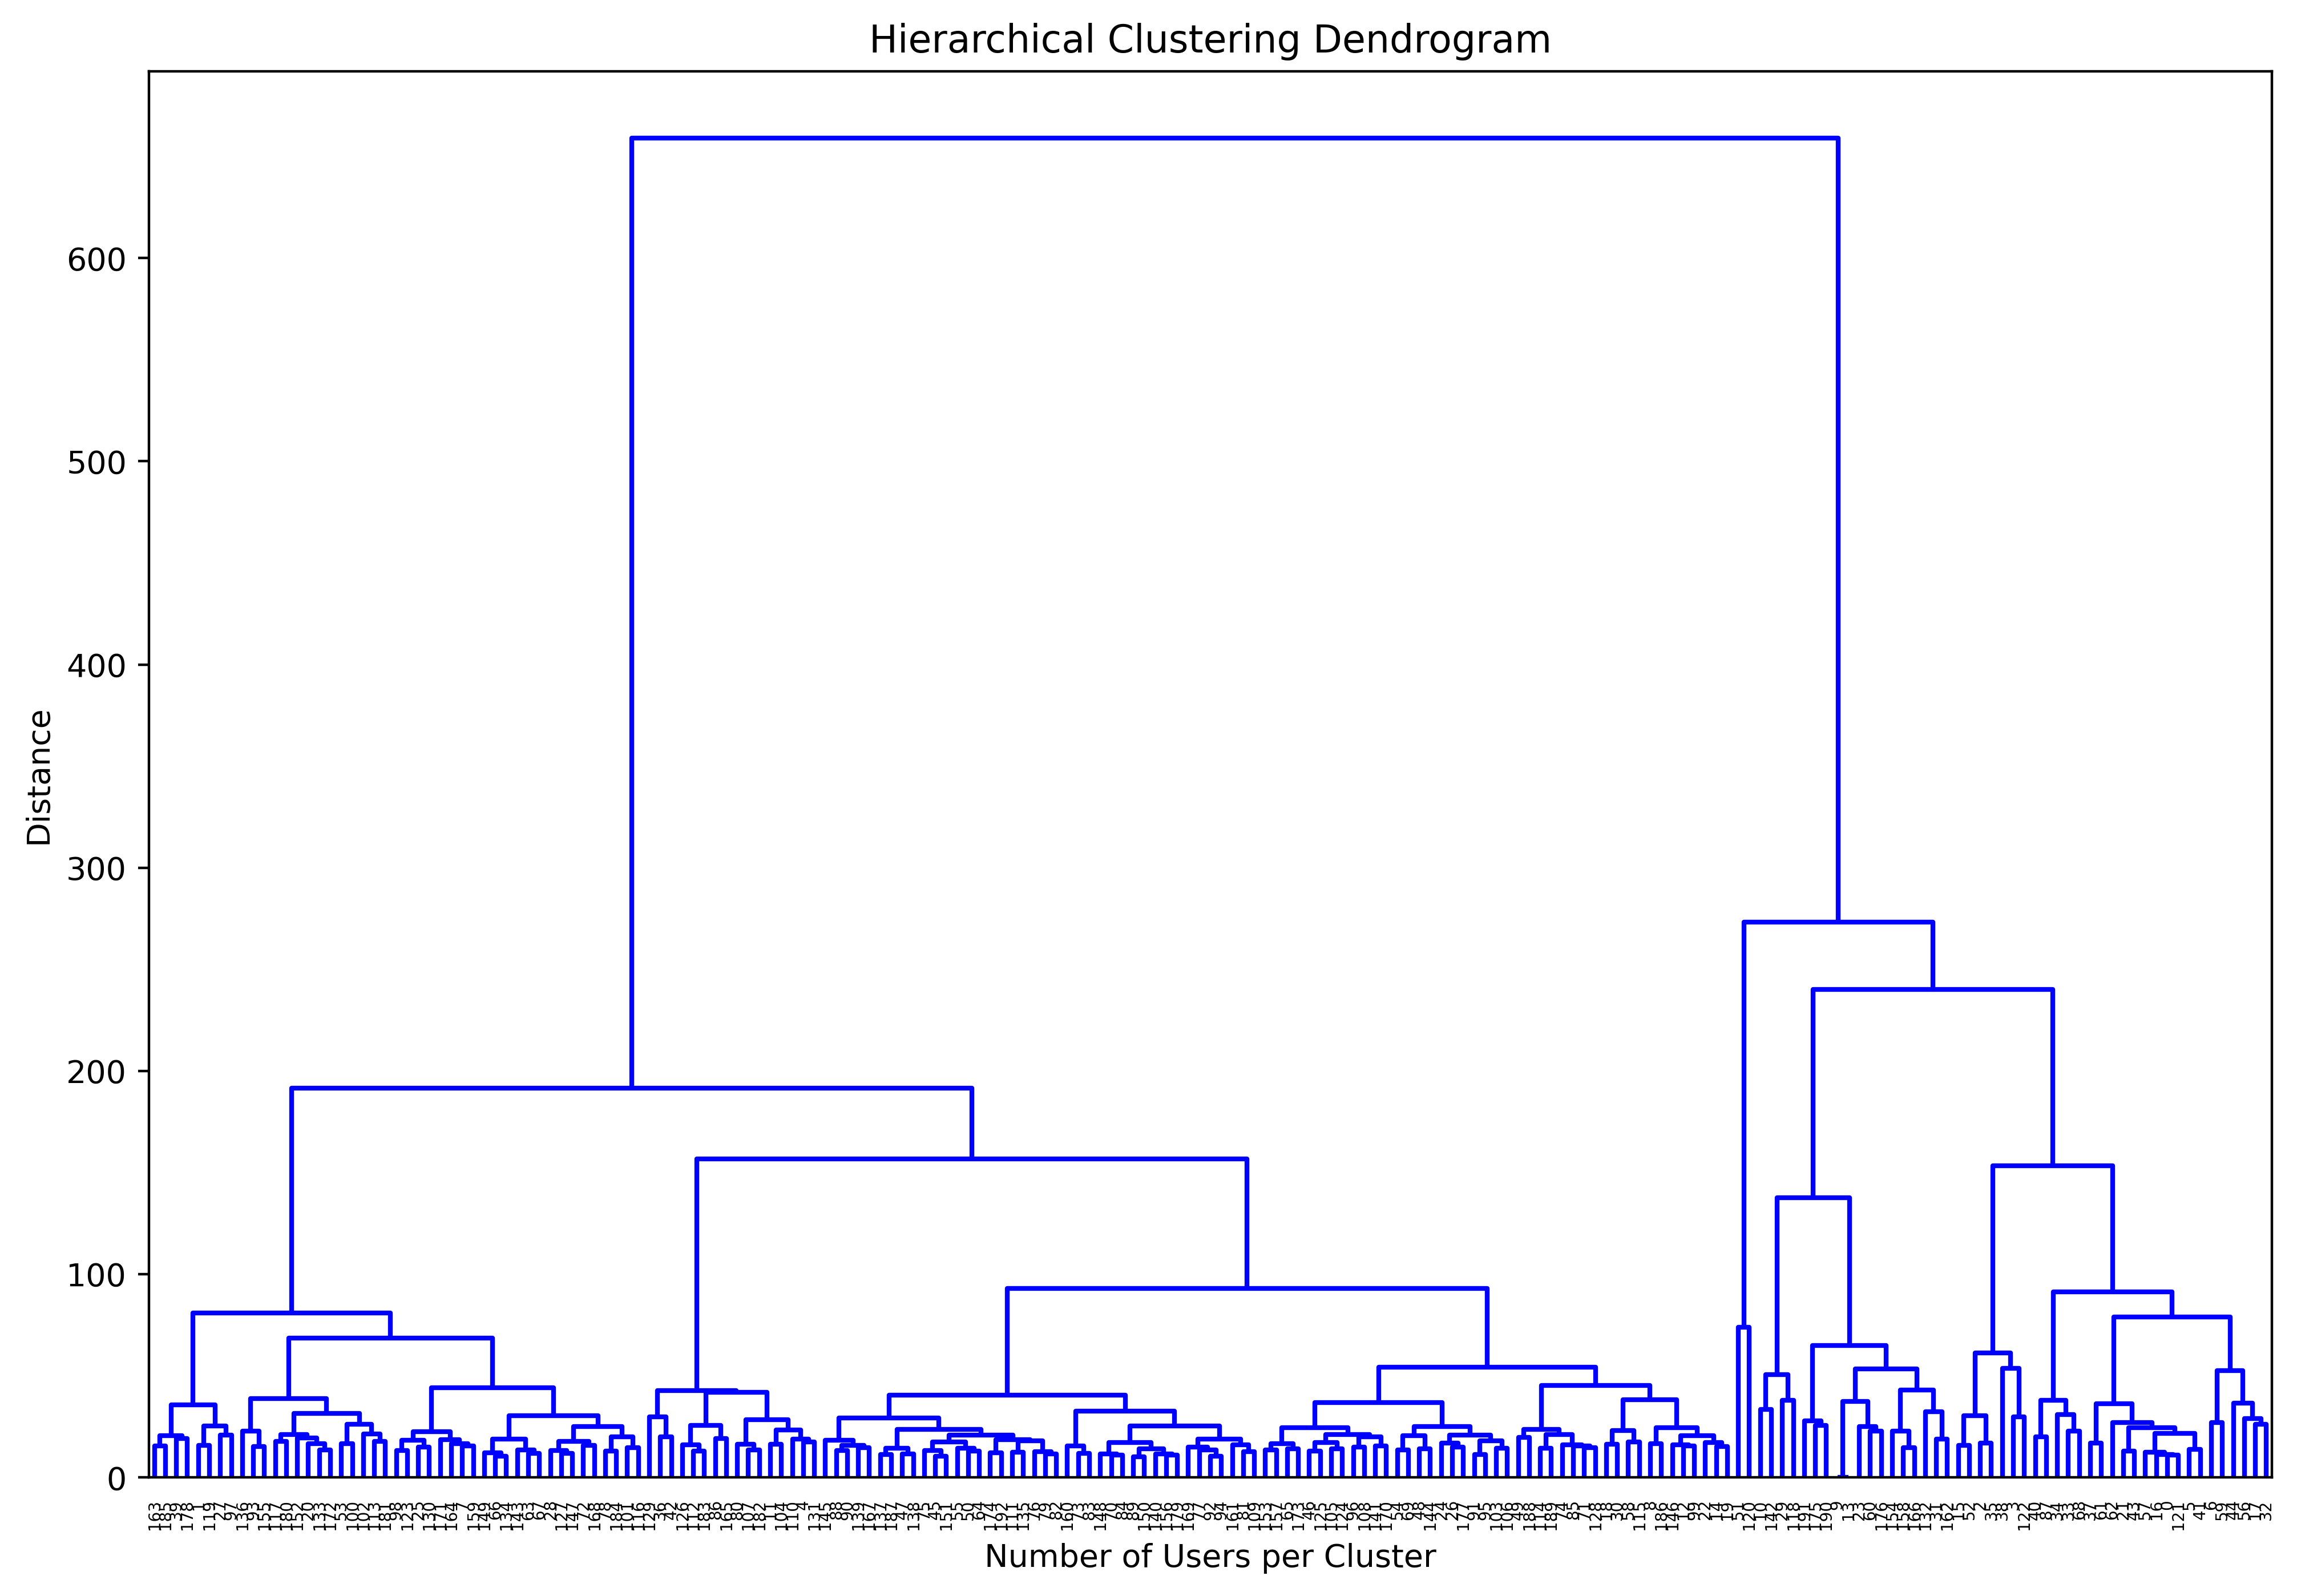

In [ ]:
# Normalize using MinMaxScaler (range 0 to 5)
scaler = MinMaxScaler(feature_range=(0, 5))
scaled_df = pd.DataFrame(scaler.fit_transform(final_df), columns=final_df.columns, index=final_df.index)

# Compute Euclidean distance matrix
def calculate_euc_relational_matrix(data):
    num_columns = data.shape[1]
    euc_matrix = np.zeros((num_columns, num_columns))
    for i in range(num_columns):
        for j in range(num_columns):
            euc_matrix[i, j] = euclidean(data.iloc[:, i].values, data.iloc[:, j].values)
    return euc_matrix

e_mat_d = calculate_euc_relational_matrix(scaled_df)

# Perform hierarchical clustering
def hierarchical_clustering(dtw_matrix, num_clusters, dpi=400):
    linkage_matrix = linkage(dtw_matrix, method="ward")
    plt.figure(figsize=(12, 8), dpi=dpi)
    dendrogram(linkage_matrix, color_threshold=0, above_threshold_color='blue')
    plt.xlabel('Number of Users per Cluster')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.show()
    return linkage_matrix

# Set number of clusters
num_clusters = 5
linkage_matrix = hierarchical_clustering(e_mat_d, num_clusters, dpi=400)
labels = fcluster(linkage_matrix, num_clusters, criterion='maxclust')


## **Display of each cluster plots and its numbers**

Number of buses per cluster:
Cluster 5: 29 buses
Cluster 1: 45 buses
Cluster 2: 99 buses
Cluster 4: 18 buses
Cluster 3: 2 buses


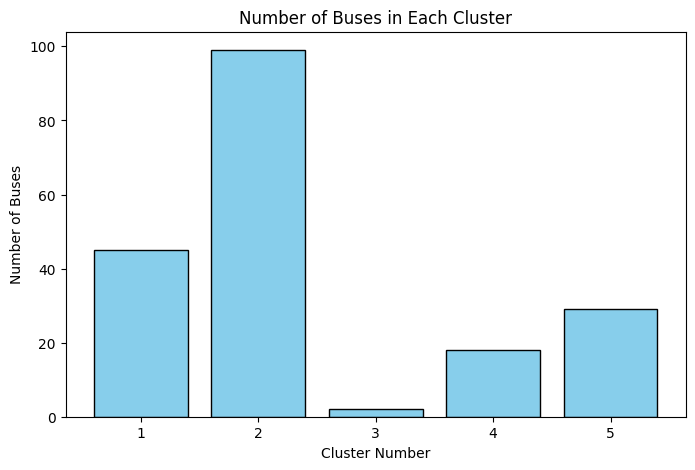

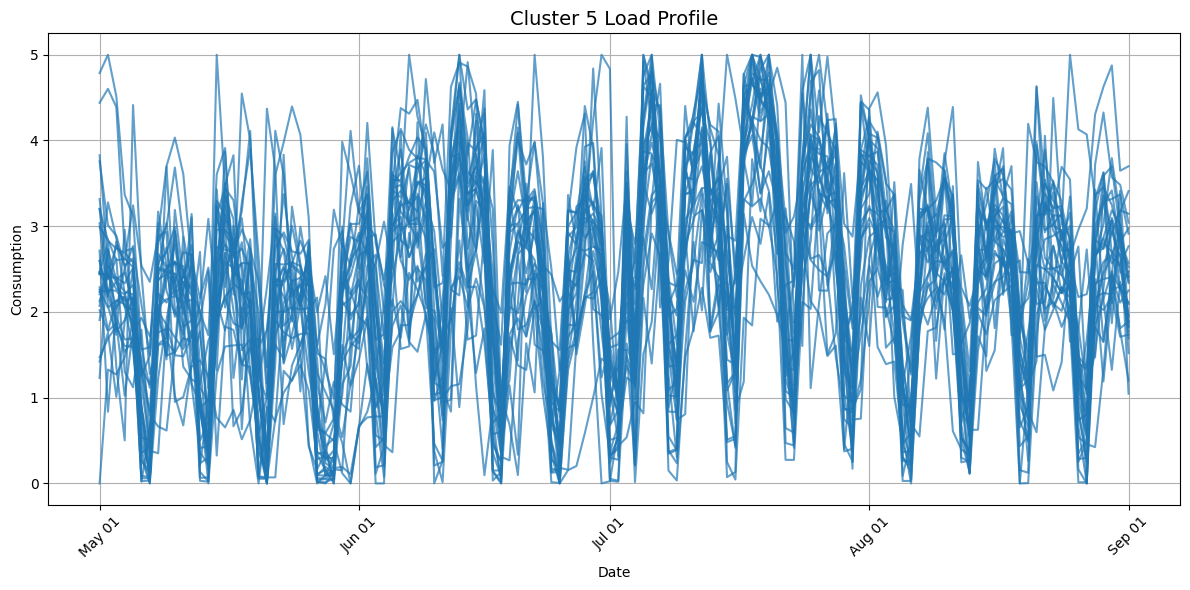

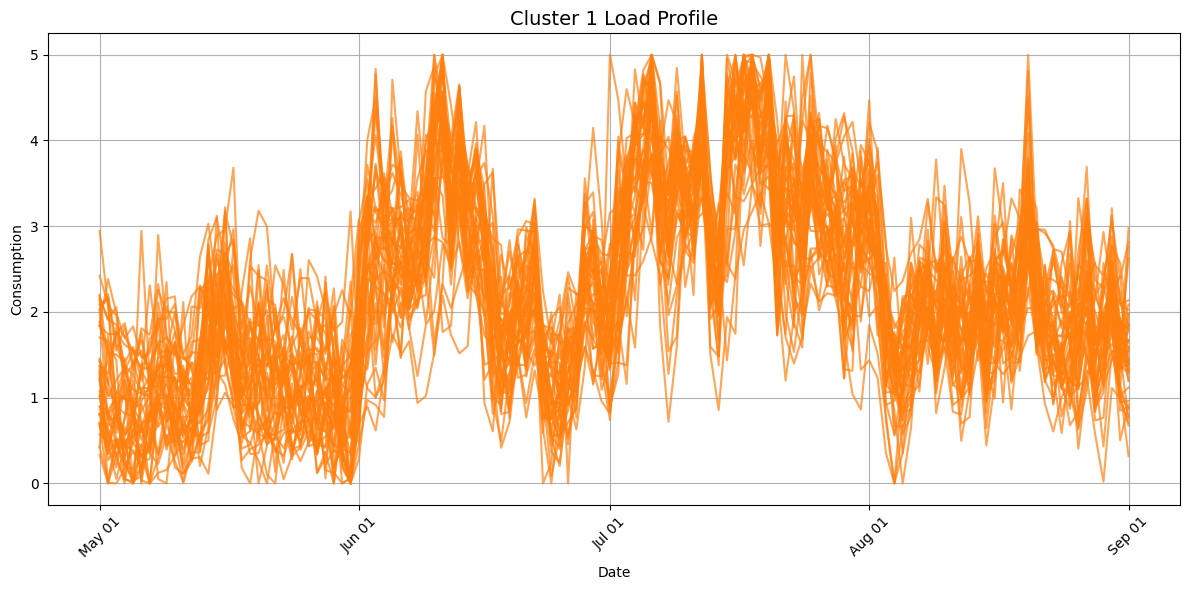

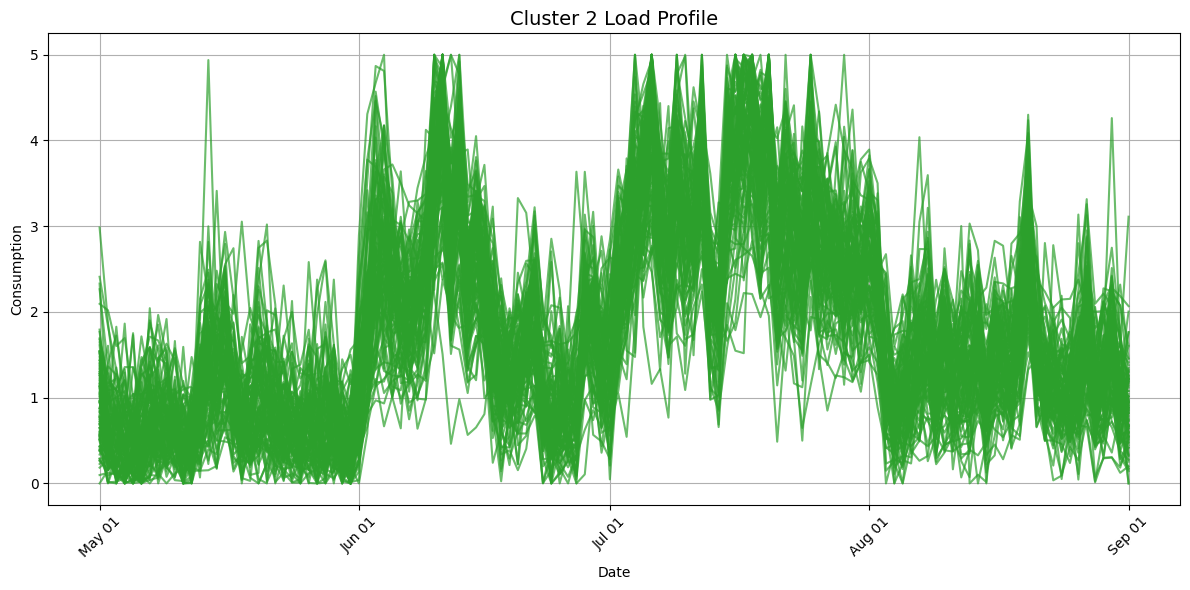

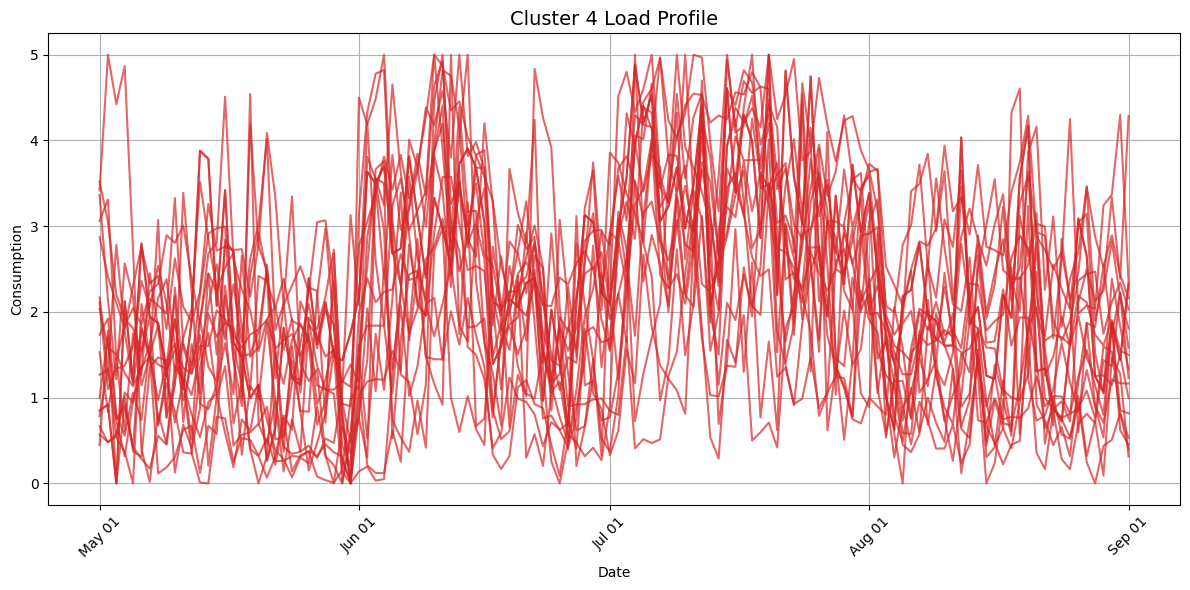

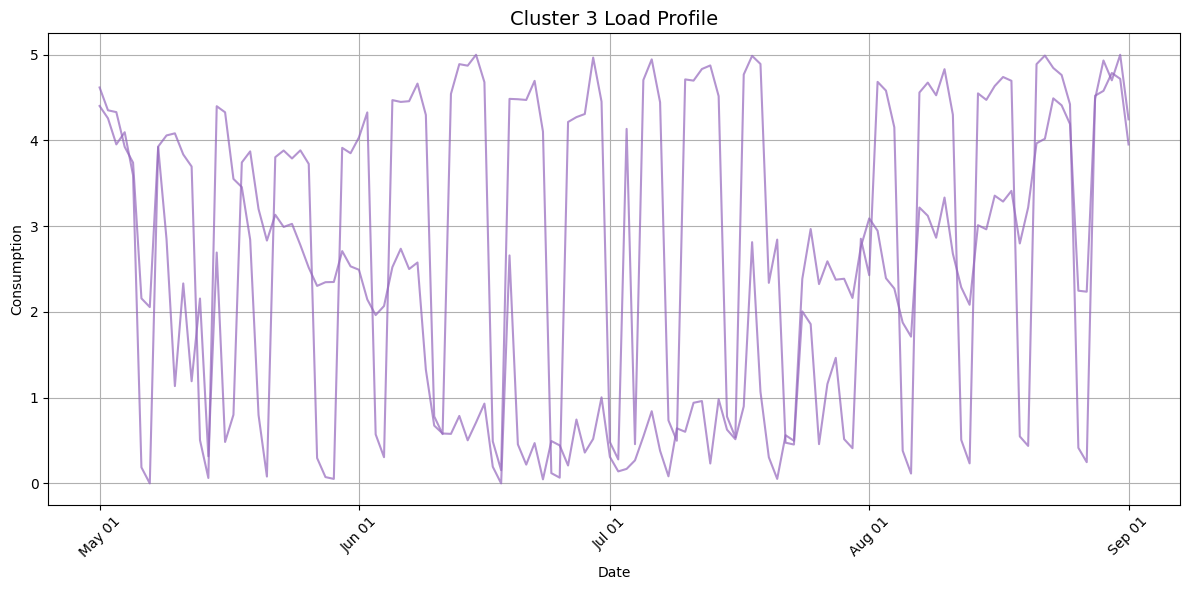

In [ ]:
# Function to separate columns by clusters
def separate_columns_by_clusters(df, clusters):
    cluster_columns = {}
    for i, cluster in enumerate(clusters):
        column_name = df.columns[i]
        if cluster in cluster_columns:
            cluster_columns[cluster].append(column_name)
        else:
            cluster_columns[cluster] = [column_name]
    return cluster_columns

# Assign columns to clusters
result = separate_columns_by_clusters(scaled_df, labels)

# Function to create DataFrames for each cluster
def create_cluster_dataframes(df, cluster_columns):
    return {cluster: df[columns] for cluster, columns in cluster_columns.items()}

# Generate cluster DataFrames
cluster_dataframes = create_cluster_dataframes(scaled_df, result)

# Count the number of buses (columns) in each cluster
num_buses_per_cluster = {cluster: len(columns) for cluster, columns in result.items()}

# Display the number of buses in each cluster
print("Number of buses per cluster:")
for cluster, num_buses in num_buses_per_cluster.items():
    print(f"Cluster {cluster}: {num_buses} buses")

# Plot the number of buses in each cluster
plt.figure(figsize=(8, 5))
plt.bar(num_buses_per_cluster.keys(), num_buses_per_cluster.values(), color='skyblue', edgecolor='black')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Buses')
plt.title('Number of Buses in Each Cluster')
plt.xticks(list(num_buses_per_cluster.keys()))
plt.show()

# Function to plot each cluster separately without legend
import matplotlib.dates as mdates

def plot_clusters_individually(cluster_dataframes):
    colors = plt.cm.tab10.colors

    for idx, (cluster, df) in enumerate(cluster_dataframes.items()):
        plt.figure(figsize=(12, 6))
        color = colors[idx % len(colors)]

        for column in df.columns:
            plt.plot(df.index, df[column], color=color, alpha=0.7)

        # Title with date range
        plt.title(
            f'Cluster {cluster} Load Profile',
            fontsize=14
        )
        plt.xlabel('Date')
        plt.ylabel('Consumption')
        plt.grid(True)

        # Date formatting
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        plt.xticks(rotation=45)

        plt.tight_layout()
        plt.show()


# Plot each cluster's consumption profile
plot_clusters_individually(cluster_dataframes)

In [ ]:
#import pandas as pd

def separate_columns_by_clusters(df, clusters):

    # Create a dictionary to store the separated clusters
    cluster_columns = {}

    # Iterate over each column index and cluster label
    for i, cluster in enumerate(clusters):
        # Get the column name
        column_name = df.columns[i]

        # Check if the cluster label already exists in the dictionary
        if cluster in cluster_columns:
            # If exists, append the column name to the existing cluster
            cluster_columns[cluster].append(column_name)
        else:
            # If doesn't exist, create a new cluster with the column name
            cluster_columns[cluster] = [column_name]

    return cluster_columns

result = separate_columns_by_clusters(scaled_df, labels)
def create_cluster_dataframes(df, cluster_columns):

    cluster_dataframes = {}

    for cluster, columns in cluster_columns.items():
        cluster_dataframes[cluster] = df[columns]

    return cluster_dataframes
cluster_dataframes = create_cluster_dataframes(scaled_df, result)

cluster_1_df = cluster_dataframes[1]
cluster_2_df = cluster_dataframes[2]
cluster_3_df = cluster_dataframes[3]
cluster_4_df = cluster_dataframes[4]
cluster_5_df = cluster_dataframes[5]

## **New Hybrid Model**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
import xgboost as xgb
import matplotlib.pyplot as plt

# ------------------ CONFIG ------------------
np.random.seed(40)
tf.random.set_seed(40)
window_size = 7
# --------------------------------------------

def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

# --- Attention Layer ---
class Attention(Layer):
    def __init__(self):
        super(Attention, self).__init__()

    def call(self, inputs):
        query = inputs
        scores = tf.matmul(query, query, transpose_b=True)
        weights = tf.nn.softmax(scores, axis=-1)
        attended = tf.matmul(weights, query)
        return attended

# --- Create lag features ---
def create_lagged_features(df, lags=7):
    df = df.copy()
    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df.iloc[:, 0].shift(i)
    df['dow'] = df.index.dayofweek
    df['rolling_mean_3'] = df.iloc[:, 0].rolling(window=3).mean()
    df['rolling_std_3'] = df.iloc[:, 0].rolling(window=3).std()
    df.dropna(inplace=True)
    return df

# --- LSTM with Attention ---
def create_attention_lstm(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    x = Attention()(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)
    model = Model(inputs=input_layer, outputs=output)
    feature_extractor = Model(inputs=input_layer, outputs=x)
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model, feature_extractor

# --- Normalize per column (user) ---
def normalize_per_column(df):
    scalers = {}
    scaled_df = df.copy()
    for col in df.columns:
        scaler = MinMaxScaler()
        scaled_df[col] = scaler.fit_transform(df[[col]])
        scalers[col] = scaler
    return scaled_df, scalers

# --- XGBoost hyperparameter tuning ---
def tune_xgboost(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.05, 0.1],
        'subsample': [0.8],
        'colsample_bytree': [0.8]
    }
    base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=10,
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=0,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_train, y_train)
    print(f"✅ Best XGBoost Params: {random_search.best_params_}")
    return xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **random_search.best_params_)

# --- Main model function with 70/15/15 split ---
def train_hybrid_model(cluster_data, cluster_id, epochs=400):
    print(f"\n🔹 Processing Cluster {cluster_id}...")
    cluster_daily = cluster_data.resample('D').sum()

    # Normalize each user independently
    scaled_df, _ = normalize_per_column(cluster_daily)

    # Feature generation
    df_features = create_lagged_features(scaled_df, lags=window_size)
    y = df_features.iloc[:, 0].values
    X = df_features.drop(columns=[df_features.columns[0]]).values

    # Indices for 70-15-15 split
    indices = np.arange(len(df_features))
    train_idx, temp_idx = train_test_split(indices, test_size=0.30, shuffle=True, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.50, shuffle=True, random_state=42)

    print(f"📦 Split → Train={len(train_idx)} | Val={len(val_idx)} | Test={len(test_idx)}")

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_val = X[val_idx]
    y_val = y[val_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # Prepare for LSTM
    X_train_lstm = X_train[:, :window_size].reshape(-1, window_size, 1)
    X_val_lstm = X_val[:, :window_size].reshape(-1, window_size, 1)
    X_test_lstm = X_test[:, :window_size].reshape(-1, window_size, 1)

    # Train LSTM with Attention
    lstm_model, feature_extractor = create_attention_lstm((window_size, 1))
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

    lstm_model.fit(
        X_train_lstm, y_train,
        validation_data=(X_val_lstm, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Extract LSTM features
    train_hidden = feature_extractor.predict(X_train_lstm)
    test_hidden = feature_extractor.predict(X_test_lstm)

    # Augment features for XGBoost
    X_train_aug = np.hstack([X_train, train_hidden])
    X_test_aug = np.hstack([X_test, test_hidden])

    # Train XGBoost
    xgb_model = tune_xgboost(X_train_aug, y_train)
    xgb_model.fit(X_train_aug, y_train)

    # Predict
    lstm_preds = lstm_model.predict(X_test_lstm).flatten()
    final_preds = xgb_model.predict(X_test_aug)

    # Evaluation
    mae = mean_absolute_error(y_test, final_preds)
    rmse = np.sqrt(mean_squared_error(y_test, final_preds))
    smape_score = smape(y_test, final_preds)

    print(f"📊 Final Test → MAE: {mae:.4f}, RMSE: {rmse:.4f}, sMAPE: {smape_score:.2f}%")

    results = [{
        "split": "70-15-15",
        "y_test": y_test,
        "lstm_preds": lstm_preds,
        "final_preds": final_preds,
        "mae": mae,
        "rmse": rmse,
        "smape": smape_score
    }]

    # Return results + models + feature names
    return results, lstm_model, feature_extractor, xgb_model, [f"f_{i}" for i in range(X_train_aug.shape[1])]


# --- Train all clusters ---
all_cluster_results = {}
trained_models = {}

for cluster_id, df in cluster_dataframes.items():
    cluster_results, lstm_model, feature_extractor, xgb_model, feature_names = train_hybrid_model(df, cluster_id)
    all_cluster_results[cluster_id] = cluster_results
    trained_models[cluster_id] = (lstm_model, feature_extractor, xgb_model, feature_names)


🔹 Processing Cluster 5...
📦 Split → Train=81 | Val=18 | Test=18
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
✅ Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 823ms/step
📊 Final Test → MAE: 0.0451, RMSE: 0.0557, sMAPE: 10.33%

🔹 Processing Cluster 1...
📦 Split → Train=81 | Val=18 | Test=18
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
✅ Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
📊 Final Test → MAE: 0.0481, RMSE: 0.0563, sMAPE: 17.47%

🔹 Processing Cluster 2...
📦 Split → Train=81 | Val=18 | Test=18
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
✅ Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
📊 Final Test → MAE: 0.0492, RMSE: 0.0774, sMAPE: 15.69%

🔹 Processing Cluster 4...
📦 Split → Train=81 | Val=18 | Test=18
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
✅ Best XGBoost Params: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.05, 'colsample_bytree': 0.8}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step
📊 Final Test → MAE: 0.0280, RMSE: 0.0348, sMAPE: 5.84%

🔹 Processing Cluster 3...
📦 Split → Train=81 | Val=18 | Test=18
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
✅ Best XGBoost Params: {'subsample': 0.

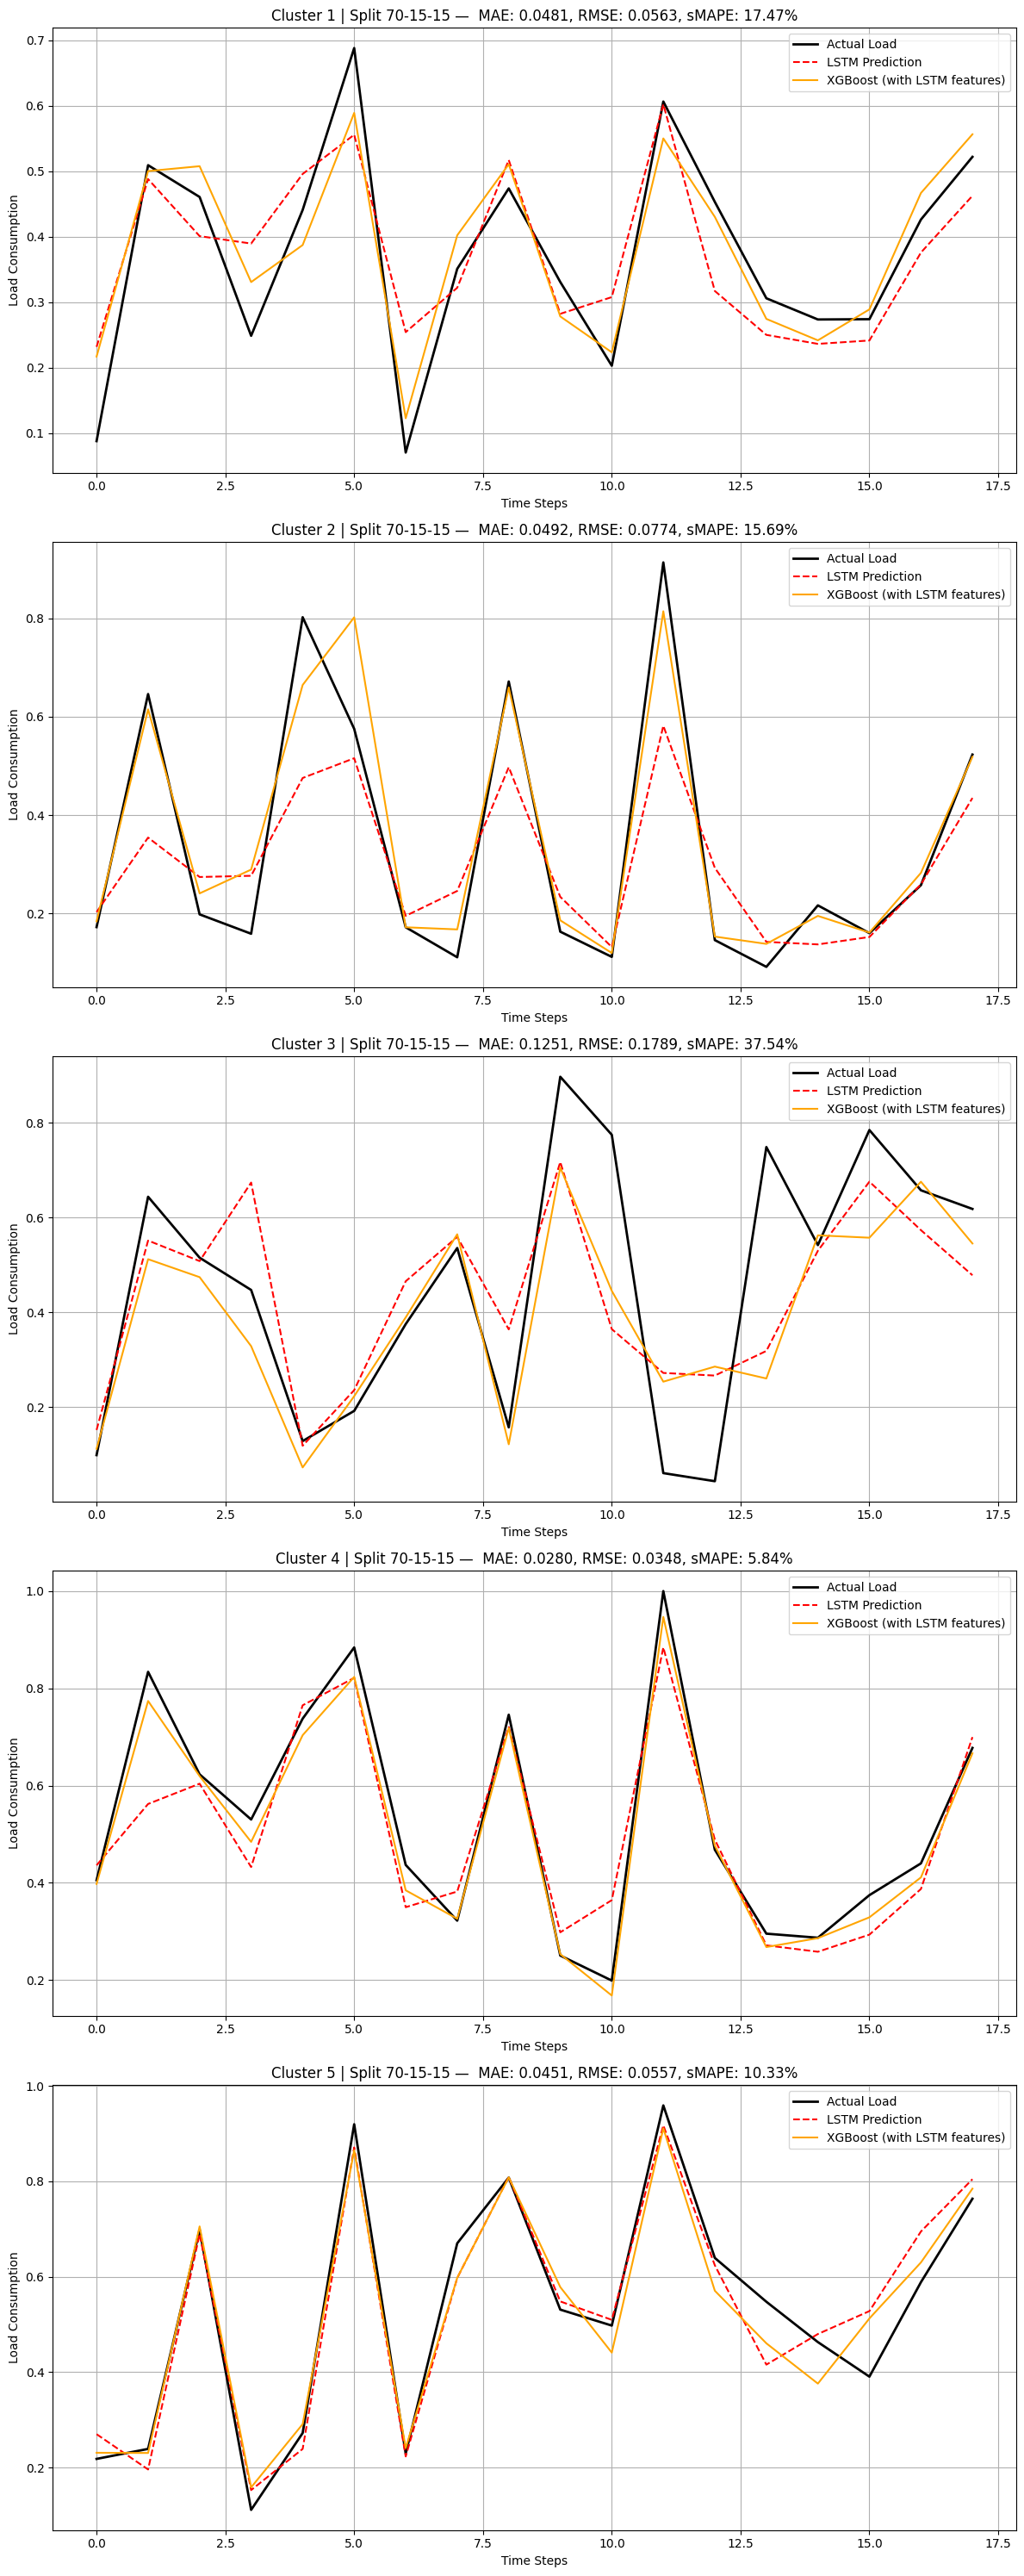

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def smape(y_true, y_pred):
    return 100 * np.mean(np.abs(y_true - y_pred) / ((np.abs(y_true) + np.abs(y_pred)) / 2))

def plot_all_cluster_predictions(all_cluster_results):
    num_clusters = len(all_cluster_results)
    fig, axes = plt.subplots(num_clusters, 1, figsize=(12, 6 * num_clusters), sharex=False)

    if num_clusters == 1:
        axes = [axes]

    for i, (cluster_id, result) in enumerate(sorted(all_cluster_results.items())):
        y_test = result[0]['y_test']
        lstm_preds = result[0]['lstm_preds']
        final_preds = result[0]['final_preds']

        ax = axes[i]
        ax.plot(y_test, label='Actual Load', color='black', linewidth=2)
        ax.plot(lstm_preds, label='LSTM Prediction', color='red', linestyle='--')
        ax.plot(final_preds, label='XGBoost (with LSTM features)', color='orange')

        ax.set_title(
            f"Cluster {cluster_id} | Split 70-15-15 —  "
            f"MAE: {result[0]['mae']:.4f}, RMSE: {result[0]['rmse']:.4f}, sMAPE: {result[0]['smape']:.2f}%",
            fontsize=12
        )
        ax.set_ylabel("Load Consumption")
        ax.set_xlabel("Time Steps")  # 👈 Ensures each plot has its own x-axis label
        ax.grid(True)
        ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()


# ✅ Call the plot function
plot_all_cluster_predictions(all_cluster_results)



## **Transfer Learning**

🔁 Transfer Learning: Using Cluster 5 to fine-tune Cluster 3 (Score: 0.497)
Epoch 1/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 0.1430 - val_loss: 0.1058 - learning_rate: 0.0010
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.1163 - val_loss: 0.0989 - learning_rate: 0.0010
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1136 - val_loss: 0.1043 - learning_rate: 0.0010
Epoch 4/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1130 - val_loss: 0.0986 - learning_rate: 0.0010
Epoch 5/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1045 - val_loss: 0.1100 - learning_rate: 0.0010
Epoch 6/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1029 - val_loss: 0.0977 - learning_rate: 0.0010
Epoch 7/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1085 - val_loss: 0.1013 - learning_rate: 0.0010
Epoch 8/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1156 - val_loss: 0.1348 - learning_rate: 0.0010
Epoch 9/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.

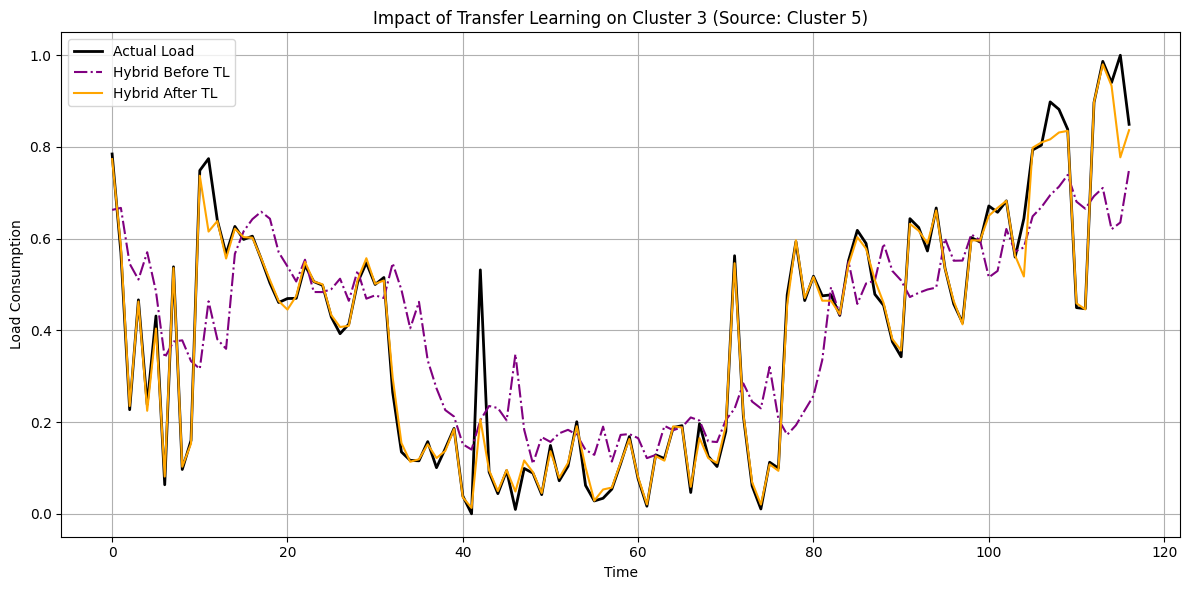

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Bidirectional, Layer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.decomposition import PCA
import xgboost as xgb
import matplotlib.pyplot as plt

# --- Custom Attention Layer with Serialization Support ---
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def call(self, inputs):
        query = inputs
        scores = tf.matmul(query, query, transpose_b=True)
        weights = tf.nn.softmax(scores, axis=-1)
        attended = tf.matmul(weights, query)
        return attended

    def get_config(self):
        config = super(Attention, self).get_config()
        return config

# --- LSTM Feature Extractor Only ---
def create_lstm_feature_extractor(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    x = Attention()(x)
    x = LSTM(32)(x)
    return None, Model(inputs=input_layer, outputs=x)

# --- LSTM Fine-tuning ---
def fine_tune_lstm(pretrained_lstm, train_data, epochs=400, batch_size=16, patience=20):
    X, y = train_data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, shuffle=True)

    for layer in pretrained_lstm.layers:
        layer.trainable = True

    pretrained_lstm.compile(optimizer='adam', loss='mae')

    early_stop = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, verbose=1)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-5, verbose=1)

    pretrained_lstm.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop, reduce_lr],
        verbose=1
    )
    return pretrained_lstm

def rebuild_lstm_model(input_shape):
    input_layer = Input(shape=input_shape)
    x = Bidirectional(LSTM(64, return_sequences=True))(input_layer)
    x = Attention()(x)
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    output = Dense(1)(x)
    return Model(inputs=input_layer, outputs=output)


# --- Distance Calculations ---
def calculate_centroid_distance(cluster_dataframes):
    centroids = {cid: df.mean(axis=1) for cid, df in cluster_dataframes.items()}
    distances = {}
    cluster_ids = list(centroids.keys())
    for i in range(len(cluster_ids)):
        for j in range(i + 1, len(cluster_ids)):
            dist = np.linalg.norm(centroids[cluster_ids[i]] - centroids[cluster_ids[j]])
            distances[(cluster_ids[i], cluster_ids[j])] = dist
    return distances

def calculate_pca_distance_fixed(cluster_dataframes):
    avg_profiles = []
    cluster_ids = []
    for cid, df in cluster_dataframes.items():
        avg_profile = df.mean(axis=1).values
        avg_profiles.append(avg_profile)
        cluster_ids.append(cid)

    avg_profiles = np.array(avg_profiles)
    pca = PCA(n_components=1)
    pca_transformed = pca.fit_transform(avg_profiles)

    distances = {}
    for i in range(len(cluster_ids)):
        for j in range(i + 1, len(cluster_ids)):
            dist = np.linalg.norm(pca_transformed[i] - pca_transformed[j])
            distances[(cluster_ids[i], cluster_ids[j])] = dist

    return distances

def find_best_transfer_cluster_combined(target_cluster_id, centroid_distances, pca_distances):
    combined_scores = {}
    max_centroid = max(centroid_distances.values())
    max_pca = max(pca_distances.values())

    for (c1, c2) in centroid_distances.keys():
        if target_cluster_id in (c1, c2):
            other = c2 if c1 == target_cluster_id else c1
            cent_dist = centroid_distances[(c1, c2)]
            pca_dist = pca_distances.get((c1, c2), pca_distances.get((c2, c1)))
            norm_score = (cent_dist / max_centroid + pca_dist / max_pca) / 2
            combined_scores[other] = norm_score

    best_cluster = min(combined_scores, key=combined_scores.get)
    best_score = combined_scores[best_cluster]
    return best_cluster, best_score

# --- Lagged Feature Creation ---
def create_lagged_features(df, lags=7):
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.date_range(start='2020-01-01', periods=len(df), freq='D')

    for i in range(1, lags + 1):
        df[f'lag_{i}'] = df.iloc[:, 0].shift(i)

    df['dow'] = df.index.dayofweek
    df['is_weekend'] = df['dow'].isin([5, 6]).astype(int)
    df['rolling_mean_3'] = df.iloc[:, 0].rolling(window=3).mean()
    df['rolling_std_3'] = df.iloc[:, 0].rolling(window=3).std()
    df['rolling_min_3'] = df.iloc[:, 0].rolling(window=3).min()
    df['rolling_max_3'] = df.iloc[:, 0].rolling(window=3).max()
    df['lag_diff_1'] = df['lag_1'] - df['lag_2']
    df.dropna(inplace=True)
    return df

# --- XGBoost Tuning ---
def tune_xgboost(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 150, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3],
        'reg_alpha': [0, 0.1],
        'min_child_weight': [1, 3, 5],
    }
    base_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    tscv = TimeSeriesSplit(n_splits=3)
    random_search = RandomizedSearchCV(
        estimator=base_model,
        param_distributions=param_grid,
        n_iter=15,
        cv=tscv,
        scoring='neg_mean_squared_error',
        verbose=0,
        n_jobs=-1,
        random_state=42
    )
    random_search.fit(X_train, y_train)
    print(f"✅ Best XGBoost Params: {random_search.best_params_}")
    return xgb.XGBRegressor(objective='reg:squarederror', random_state=42, **random_search.best_params_)

# --- Plot Results ---
def plot_transfer_learning_results(y_actual, lstm_preds_before, lstm_preds_after, xgb_preds, final_preds_before, final_preds_after, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_actual, label="Actual Load", color='black', linewidth=2)
    plt.plot(final_preds_before, label="Hybrid Before TL", linestyle='dashdot', color='purple')
    plt.plot(final_preds_after, label="Hybrid After TL", linestyle='solid', color='orange')
    plt.xlabel("Time")
    plt.ylabel("Load Consumption")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# --- Main Transfer Learning Function ---
def apply_transfer_learning(cluster_dataframes, trained_models, target_cluster, epochs=400):
    centroid_distances = calculate_centroid_distance(cluster_dataframes)
    pca_distances = calculate_pca_distance_fixed(cluster_dataframes)
    best_cluster, best_distance = find_best_transfer_cluster_combined(
        target_cluster, centroid_distances, pca_distances
    )
    print(f"🔁 Transfer Learning: Using Cluster {best_cluster} to fine-tune Cluster {target_cluster} (Score: {best_distance:.3f})")

    pretrained_lstm_model, pretrained_feature_extractor, pretrained_xgb, xgb_feature_names = trained_models[best_cluster]

    df_target = cluster_dataframes[target_cluster]
    df_target_daily = df_target.resample('D').sum()

    scaler = MinMaxScaler()
    scaled_target = scaler.fit_transform(df_target_daily)
    df_scaled_target = pd.DataFrame(scaled_target, index=df_target_daily.index, columns=df_target_daily.columns)

    df_lagged = create_lagged_features(df_scaled_target, lags=7)
    y_new = df_lagged.iloc[:, 0].values
    X_new = df_lagged.drop(columns=[df_lagged.columns[0]]).values
    X_new_lstm = X_new[:, :7].reshape(-1, 7, 1)

    # Rebuild and fine-tune LSTM
    input_shape = (X_new_lstm.shape[1], X_new_lstm.shape[2])
    fine_tuned_lstm = rebuild_lstm_model(input_shape)
    fine_tuned_lstm.set_weights(pretrained_lstm_model.get_weights())
    fine_tuned_lstm = fine_tune_lstm(fine_tuned_lstm, (X_new_lstm, y_new), epochs=epochs)

    # Feature extractor
    _, fine_tuned_feature_extractor = create_lstm_feature_extractor(input_shape)
    fine_tuned_feature_extractor.set_weights(fine_tuned_lstm.get_weights()[:len(fine_tuned_feature_extractor.get_weights())])

    hidden_features_before = pretrained_feature_extractor.predict(X_new_lstm)
    hidden_features_after = fine_tuned_feature_extractor.predict(X_new_lstm)

    X_new_aug_before = np.hstack([X_new, hidden_features_before])
    X_new_aug_after = np.hstack([X_new, hidden_features_after])

    feature_names_before = [f"f_{i}" for i in range(X_new_aug_before.shape[1])]
    X_new_aug_before_df = pd.DataFrame(X_new_aug_before, columns=feature_names_before)
    X_new_aug_before_df = X_new_aug_before_df.reindex(columns=xgb_feature_names, fill_value=0)

    feature_names_after = [f"f_{i}" for i in range(X_new_aug_after.shape[1])]
    X_new_aug_after_df = pd.DataFrame(X_new_aug_after, columns=feature_names_after)

    # Train XGBoost on 90% of new data
    X_train, _, y_train, _ = train_test_split(X_new_aug_after_df.values, y_new, test_size=0.1, shuffle=True)
    new_xgb = tune_xgboost(X_train, y_train)
    new_xgb.fit(X_train, y_train)

    lstm_preds_before = pretrained_lstm_model.predict(X_new_lstm).flatten()
    lstm_preds_after = fine_tuned_lstm.predict(X_new_lstm).flatten()
    xgb_preds_before = pretrained_xgb.predict(X_new_aug_before_df.values)
    xgb_preds_after = new_xgb.predict(X_new_aug_after_df.values)

    # 🔁 Optimize blend ratio
    def optimize_blend(y_true, lstm_pred, xgb_pred):
        best_w = 0
        best_score = float('inf')
        for w in np.arange(0, 1.05, 0.05):
            blend = w * lstm_pred + (1 - w) * xgb_pred
            score = smape(y_true, blend)
            if score < best_score:
                best_score = score
                best_w = w
        return best_w, best_score

    w_before, smape_before = optimize_blend(y_new, lstm_preds_before, xgb_preds_before)
    w_after, smape_after = optimize_blend(y_new, lstm_preds_after, xgb_preds_after)

    final_preds_before = w_before * lstm_preds_before + (1 - w_before) * xgb_preds_before
    final_preds_after = w_after * lstm_preds_after + (1 - w_after) * xgb_preds_after

    mae_before = mean_absolute_error(y_new, final_preds_before)
    rmse_before = np.sqrt(mean_squared_error(y_new, final_preds_before))

    mae_after = mean_absolute_error(y_new, final_preds_after)
    rmse_after = np.sqrt(mean_squared_error(y_new, final_preds_after))

    print(f"\n📉 Metrics BEFORE Transfer Learning (Blend {w_before:.2f} LSTM):")
    print(f"   MAE:   {mae_before:.4f}")
    print(f"   RMSE:  {rmse_before:.4f}")
    print(f"   sMAPE: {smape_before:.2f}%")

    print(f"\n✅ Metrics AFTER Transfer Learning (Blend {w_after:.2f} LSTM):")
    print(f"   MAE:   {mae_after:.4f}")
    print(f"   RMSE:  {rmse_after:.4f}")
    print(f"   sMAPE: {smape_after:.2f}%")

    return (
        fine_tuned_lstm,
        new_xgb,
        best_cluster,
        y_new,
        lstm_preds_before,
        lstm_preds_after,
        final_preds_before,
        final_preds_after,
        {
            "before": {"mae": mae_before, "rmse": rmse_before, "smape": smape_before},
            "after": {"mae": mae_after, "rmse": rmse_after, "smape": smape_after},
        }
    )



# Example: Transfer learning on target cluster 3
target_cluster = 3
fine_tuned_model, xgb_model, best_cluster, y_new, lstm_preds_before, lstm_preds_after, final_preds_before, final_preds_after, metrics = apply_transfer_learning(
    cluster_dataframes,
    trained_models,
    target_cluster=target_cluster
)

plot_transfer_learning_results(
    y_actual=y_new,
    lstm_preds_before=lstm_preds_before,
    lstm_preds_after=lstm_preds_after,
    xgb_preds=None,
    final_preds_before=final_preds_before,
    final_preds_after=final_preds_after,
    title=f"Impact of Transfer Learning on Cluster {target_cluster} (Source: Cluster {best_cluster})"
)